<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/reduce_features/notebooks/CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!git clone -b reduce_features https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


In [15]:
# Cell 1: Imports & Paths
import os
import math
import random
import time
import json
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Project paths (as you specified)
PROJECT_ROOT = Path('/content/ann-visual-emotion')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL   = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST  = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
DATA_DIR  = PROJECT_ROOT / 'data/raw/EmoSet'

print("Project root:", PROJECT_ROOT)

# Basic existence checks
for p in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH, DATA_DIR]:
    print(f"{p}: {'OK' if p.exists() else 'MISSING'}")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Project root: /content/ann-visual-emotion
/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json: OK
/content/ann-visual-emotion/data/raw/EmoSet: OK
Device: cuda


In [16]:
# Cell 2: Config & Feature Toggles

# CSV column names
IMAGE_COL = "filepath"   # adjust if different
LABEL_COL = "label"        # adjust if different

# Load label map & derive classes
def load_label_map(path: Path):
    with open(path, 'r') as f:
        lm = json.load(f)
    # Try to detect structure
    # Case 1: dict label->int
    if isinstance(lm, dict):
        # If values are int and unique, assume label->id
        if all(isinstance(v, int) for v in lm.values()):
            return lm  # label -> id
        # If values are str, maybe id->label
        if all(isinstance(v, str) for v in lm.values()):
            # invert to label->id
            inv = {v: int(k) for k, v in lm.items()}
            return inv
    # Case 2: list of labels
    if isinstance(lm, list):
        return {label: idx for idx, label in enumerate(lm)}
    raise ValueError("Unrecognized label map format.")

label_map = load_label_map(LABEL_MAP_PATH)
# Sort by id to get consistent class order
CLASSES = [lbl for lbl, _id in sorted(label_map.items(), key=lambda x: x[1])]
class_to_idx = {c: i for i, c in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

print("Classes:", CLASSES)

# Training hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 55
PATIENCE = 8
WARMUP_EPOCHS = 3
BASE_LR_BACKBONE = 1e-4
BASE_LR_HEAD = 1e-3
WEIGHT_DECAY = 1e-4

# Feature toggles
USE_MIXUP = True
MIXUP_ALPHA = 0.4
USE_LABEL_SMOOTHING = True
LABEL_SMOOTHING = 0.05
USE_WEIGHTED_SAMPLER = False   # set True if imbalance observed
USE_SWA = False
GRADUAL_UNFREEZE = True
FREEZE_EPOCHS = 3

# SWA config
SWA_START_EPOCH = 45
SWA_LR = 5e-4

PRINT_FREQ = 50

print("Configuration loaded.")

Classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']
Configuration loaded.


In [17]:
# Cell 3: Dataset Class

class EmotionDataset(Dataset):
    def __init__(self, df, image_col, label_col, class_to_idx, transform=None, data_root: Path = None):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.data_root = data_root

    def resolve_path(self, raw_path):
        p = Path(raw_path)
        if p.is_absolute() and p.exists():
            return p
        # Try relative to data_root
        if self.data_root is not None:
            candidate = self.data_root / p
            if candidate.exists():
                return candidate
        # Try relative to project root
        candidate = PROJECT_ROOT / p
        if candidate.exists():
            return candidate
        return p  # fallback (might raise later if missing)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path_raw = row[self.image_col]
        img_path = self.resolve_path(img_path_raw)
        label_name = row[self.label_col]
        label = self.class_to_idx[label_name]

        if not img_path.exists():
            raise FileNotFoundError(f"Image not found: {img_path} (from '{img_path_raw}')")

        with Image.open(img_path) as img:
            img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [18]:
# Cell 4: Transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.25, 0.25, 0.25, 0.10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), value='random')
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_transform = val_transform

In [19]:
# Cell 5: Load DataFrames & Datasets

train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

print("Train size:", len(train_df), "Val size:", len(val_df), "Test size:", len(test_df))

train_dataset = EmotionDataset(train_df, IMAGE_COL, LABEL_COL, class_to_idx,
                               transform=train_transform, data_root=DATA_DIR)
val_dataset   = EmotionDataset(val_df, IMAGE_COL, LABEL_COL, class_to_idx,
                               transform=val_transform, data_root=DATA_DIR)
test_dataset  = EmotionDataset(test_df, IMAGE_COL, LABEL_COL, class_to_idx,
                                transform=test_transform, data_root=DATA_DIR)

Train size: 20150 Val size: 4030 Test size: 1005


In [20]:
# Cell 6: DataLoaders

if USE_WEIGHTED_SAMPLER:
    counts = Counter(train_df[LABEL_COL])
    inv_freq = {lbl: 1.0 / c for lbl, c in counts.items()}
    sample_weights = train_df[LABEL_COL].map(inv_freq).values
    sample_weights = torch.DoubleTensor(sample_weights)
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=2, pin_memory=True)

print("DataLoaders ready.")

DataLoaders ready.


In [21]:
# Cell 7: Model Builder

def build_model(num_classes, backbone_name="resnet18", pretrained=True, dropout_p=0.25):
    if backbone_name == "resnet18":
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        feat_dim = backbone.fc.in_features
        feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
    else:
        raise ValueError("Unsupported backbone for this template.")

    classifier = nn.Sequential(
        nn.Linear(feat_dim, 512),
        nn.ReLU(inplace=True),
        nn.LayerNorm(512),
        nn.Dropout(dropout_p),
        nn.Linear(512, num_classes)
    )

    m = nn.Module()
    m.features = feature_extractor
    m.classifier = classifier

    def forward(x):
        x = m.features(x)
        x = torch.flatten(x, 1)
        x = m.classifier(x)
        return x

    m.forward = forward
    return m

model = build_model(NUM_CLASSES)
model = model.to(device)
print(model)

Module(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [22]:
# Cell 8: Criterion, Optimizer, Scheduler

backbone_params = list(model.features.parameters())
head_params = list(model.classifier.parameters())

if USE_LABEL_SMOOTHING:
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    [
        {"params": backbone_params, "lr": BASE_LR_BACKBONE},
        {"params": head_params, "lr": BASE_LR_HEAD},
    ],
    weight_decay=WEIGHT_DECAY
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / WARMUP_EPOCHS
    progress = (epoch - WARMUP_EPOCHS) / max(1, (NUM_EPOCHS - WARMUP_EPOCHS))
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=[lr_lambda, lr_lambda]
)

if USE_SWA:
    from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=SWA_LR)

print("Optimizer & scheduler ready.")

Optimizer & scheduler ready.


/tmp/ipython-input-897893772.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [23]:
# Cell 9: Mixup Utility

def apply_mixup(inputs, targets, alpha=0.4):
    if alpha is None or alpha <= 0:
        return inputs, (targets, targets, 1.0), False
    lam = np.random.beta(alpha, alpha)
    bs = inputs.size(0)
    index = torch.randperm(bs, device=inputs.device)
    mixed = lam * inputs + (1 - lam) * inputs[index]
    ta, tb = targets, targets[index]
    return mixed, (ta, tb, lam), True

In [24]:
# Cell 10: Train / Eval

def train_epoch(model, loader, optimizer, device, criterion, scaler=None,
                use_mixup=False, mixup_alpha=0.4, epoch=0,
                freeze_backbone=False):
    model.train()

    if freeze_backbone:
        for p in model.features.parameters():
            p.requires_grad = False
    else:
        for p in model.features.parameters():
            p.requires_grad = True

    total = 0
    run_loss = 0.0
    run_correct = 0.0

    for batch_idx, (imgs, labels) in enumerate(loader):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_mixup:
            imgs, (ta, tb, lam), mixed = apply_mixup(imgs, labels, alpha=mixup_alpha)
        else:
            mixed = False

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            out = model(imgs)
            if mixed:
                loss = lam * criterion(out, ta) + (1 - lam) * criterion(out, tb)
            else:
                loss = criterion(out, labels)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        batch_size = imgs.size(0)
        run_loss += loss.item() * batch_size
        preds = out.argmax(1)

        if mixed:
            run_correct += (lam * preds.eq(ta).sum().item() +
                            (1 - lam) * preds.eq(tb).sum().item())
        else:
            run_correct += preds.eq(labels).sum().item()
        total += batch_size

        if (batch_idx + 1) % PRINT_FREQ == 0:
            print(f"Batch {batch_idx+1}/{len(loader)} Loss {loss.item():.4f}")

    return run_loss / total, run_correct / total


@torch.no_grad()
def eval_epoch(model, loader, device, criterion):
    model.eval()
    total = 0
    run_loss = 0.0
    run_correct = 0

    preds_all = []
    targets_all = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        out = model(imgs)
        loss = criterion(out, labels)
        batch_size = imgs.size(0)
        run_loss += loss.item() * batch_size
        preds = out.argmax(1)
        run_correct += preds.eq(labels).sum().item()
        total += batch_size
        preds_all.append(preds.cpu())
        targets_all.append(labels.cpu())

    preds_all = torch.cat(preds_all).numpy()
    targets_all = torch.cat(targets_all).numpy()
    return run_loss / total, run_correct / total, preds_all, targets_all

In [25]:
# Cell 11: Early Stopping

class EarlyStopper:
    def __init__(self, patience=8, mode='max', min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.num_bad = 0
        self.should_stop = False

    def step(self, value):
        if self.best is None:
            self.best = value
            return False
        improve = (value - self.best) if self.mode == 'max' else (self.best - value)
        if self.mode == 'max':
            if improve > self.min_delta:
                self.best = value
                self.num_bad = 0
            else:
                self.num_bad += 1
        else:
            if improve > self.min_delta:
                self.best = value
                self.num_bad = 0
            else:
                self.num_bad += 1
        if self.num_bad >= self.patience:
            self.should_stop = True
        return self.should_stop

early_stopper = EarlyStopper(patience=PATIENCE, mode='max')

In [26]:
# Cell 12: Training Loop

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

best_val_acc = -1
best_state = None
start = time.time()

for epoch in range(NUM_EPOCHS):
    freeze_backbone = GRADUAL_UNFREEZE and (epoch < FREEZE_EPOCHS)
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (freeze_backbone={freeze_backbone})")

    tr_loss, tr_acc = train_epoch(
        model, train_loader, optimizer, device, criterion, scaler,
        use_mixup=USE_MIXUP, mixup_alpha=MIXUP_ALPHA,
        epoch=epoch, freeze_backbone=freeze_backbone
    )

    if USE_SWA and epoch >= SWA_START_EPOCH:
        swa_scheduler.step()
    else:
        scheduler.step()

    val_loss, val_acc, _, _ = eval_epoch(model, val_loader, device, criterion)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)

    print(f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f}")
    print(f"Val   Loss {val_loss:.4f} Acc {val_acc:.4f}")
    print("LRs:", [pg['lr'] for pg in optimizer.param_groups])

    if USE_SWA and epoch >= SWA_START_EPOCH:
        swa_model.update_parameters(model)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {
            "epoch": epoch,
            "model": model.state_dict(),
            "val_acc": val_acc
        }

    if early_stopper.step(val_acc):
        print("Early stopping triggered.")
        break

elapsed = (time.time() - start) / 60
print(f"\nFinished. Best Val Acc {best_val_acc:.4f} at epoch {best_state['epoch']+1}. Time {elapsed:.2f} min")

if USE_SWA:
    from torch.optim.swa_utils import update_bn
    print("Updating SWA BN stats...")
    update_bn(train_loader, swa_model)
    final_model = swa_model
else:
    final_model = model

if not USE_SWA and best_state is not None:
    model.load_state_dict(best_state["model"])


Epoch 1/55 (freeze_backbone=True)


/tmp/ipython-input-336459408.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Batch 50/630 Loss 1.6077
Batch 100/630 Loss 1.5299
Batch 150/630 Loss 1.4711
Batch 200/630 Loss 1.3076
Batch 250/630 Loss 1.4955
Batch 300/630 Loss 1.4736
Batch 350/630 Loss 1.5410
Batch 400/630 Loss 1.6770
Batch 450/630 Loss 1.6076
Batch 500/630 Loss 1.3732
Batch 550/630 Loss 1.4149
Batch 600/630 Loss 1.6117
Train Loss 1.5204 Acc 0.3339
Val   Loss 1.4100 Acc 0.4099
LRs: [6.666666666666667e-05, 0.0006666666666666666]

Epoch 2/55 (freeze_backbone=True)
Batch 50/630 Loss 1.5651
Batch 100/630 Loss 1.3691
Batch 150/630 Loss 1.3794
Batch 200/630 Loss 1.4731
Batch 250/630 Loss 1.4782
Batch 300/630 Loss 1.3718
Batch 350/630 Loss 1.3814
Batch 400/630 Loss 1.6234
Batch 450/630 Loss 1.6007
Batch 500/630 Loss 1.5026
Batch 550/630 Loss 1.5409
Batch 600/630 Loss 1.2943
Train Loss 1.4710 Acc 0.3696
Val   Loss 1.3743 Acc 0.4347
LRs: [0.0001, 0.001]

Epoch 3/55 (freeze_backbone=True)
Batch 50/630 Loss 1.2183
Batch 100/630 Loss 1.3254
Batch 150/630 Loss 1.3577
Batch 200/630 Loss 1.5749
Batch 250/630 Lo

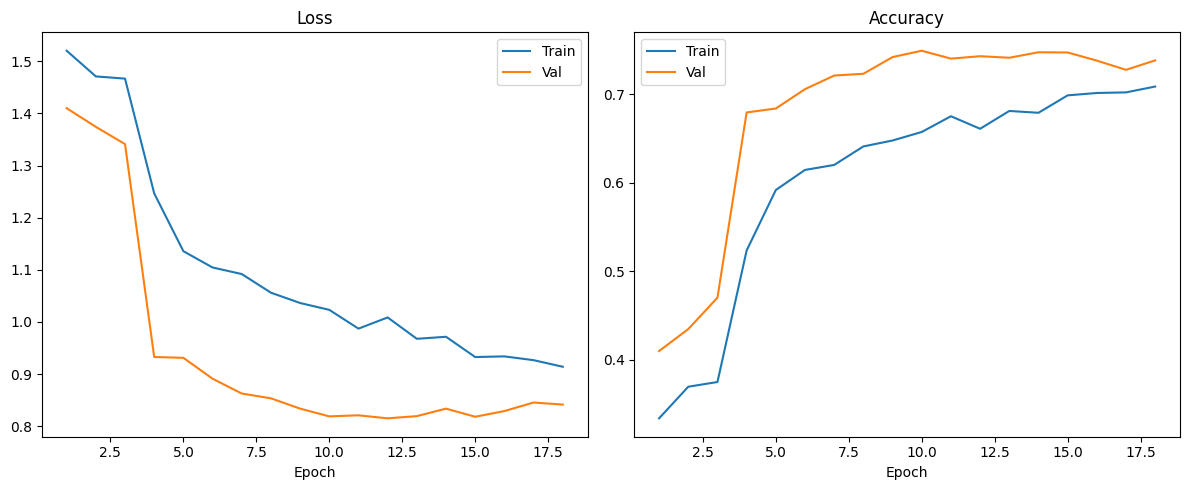

In [27]:
# Cell 13: Curves

epochs_r = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_r, history["train_loss"], label="Train")
plt.plot(epochs_r, history["val_loss"], label="Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_r, history["train_acc"], label="Train")
plt.plot(epochs_r, history["val_acc"], label="Val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 0.8724  Test Acc: 0.7264

Classification Report:
              precision    recall  f1-score   support

       angry     0.7734    0.4925    0.6018       201
       happy     0.8827    0.7861    0.8316       201
     neutral     0.6593    0.7413    0.6979       201
         sad     0.5486    0.7015    0.6157       201
    surprise     0.8512    0.9104    0.8798       201

    accuracy                         0.7264      1005
   macro avg     0.7430    0.7264    0.7254      1005
weighted avg     0.7430    0.7264    0.7254      1005



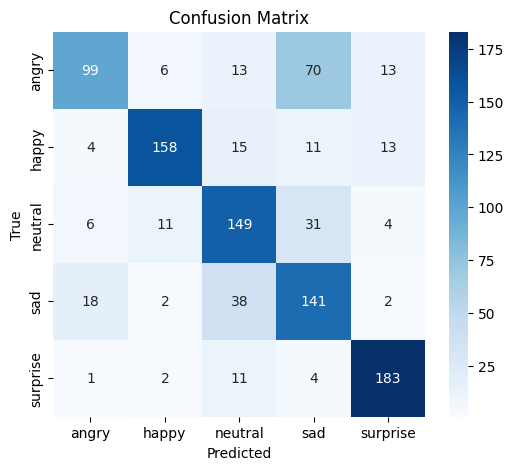

In [28]:
# Cell 14: Test Evaluation

test_loss, test_acc, test_preds, test_targets = eval_epoch(
    final_model if USE_SWA else model,
    test_loader,
    device,
    criterion
)

print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(test_targets, test_preds, target_names=CLASSES, digits=4))

cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [29]:
# Cell 15: Save Artifacts

art_dir = PROJECT_ROOT / "artifacts"
art_dir.mkdir(parents=True, exist_ok=True)

model_path = art_dir / "best_model.pth"
torch.save(best_state["model"], model_path)

history_path = art_dir / "history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

print("Saved:")
print(" -", model_path)
print(" -", history_path)

Saved:
 - /content/ann-visual-emotion/artifacts/best_model.pth
 - /content/ann-visual-emotion/artifacts/history.json


In [30]:
# Cell 16: Inference Helper

@torch.no_grad()
def predict_image(img_path, model=None, transform=None):
    p = Path(img_path)
    if model is None:
        m = build_model(NUM_CLASSES)
        state = torch.load(PROJECT_ROOT / "artifacts/best_model.pth", map_location=device)
        m.load_state_dict(state)
        m.to(device)
        m.eval()
    else:
        m = model
        m.eval()

    if transform is None:
        transform = val_transform

    with Image.open(p) as img:
        img = img.convert("RGB")
    t = transform(img).unsqueeze(0).to(device)
    logits = m(t)
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    top_idx = probs.argmax()
    return {
        "pred_class": CLASSES[top_idx],
        "probs": {CLASSES[i]: float(prob) for i, prob in enumerate(probs)}
    }

# Example:
# result = predict_image("/content/ann-visual-emotion/data/raw/EmoSet/some_image.jpg")
# result